In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from model import RidgeRegression
from selection import KFoldCV, NestedCV

In [2]:
def get_weights(data, target, model, name):
    val = data.columns.values.tolist()
    val.remove(target)
    return pd.DataFrame(data=model.get_weight(), index=val, columns=[name])

Carichiamo i dataset elaborati ottenuti dal notebook elaboration e definiamo la funzione di loss

In [3]:
def mean_squared_error(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    return np.mean((y_true-y_pred)**2, axis=0)

def r2_score(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    mean = np.average(y_true, axis=0)
    numerator = ((y_true - y_pred) ** 2).sum(axis=0, dtype=np.float64)
    denominator = ((y_true - mean) ** 2).sum(axis=0, dtype=np.float64)
    return  1 - (numerator /denominator)

dataA = ("base", pd.read_pickle("./base.pkl"))
dataB = ("base no out", pd.read_pickle("./base_no_out.pkl"))
dataC = ("add features", pd.read_pickle("./add_features.pkl"))
dataD = ("log", pd.read_pickle("./log.pkl"))
dataE = ("removed", pd.read_pickle("./removed.pkl"))

dataA_PCA = ("PCA base", pd.read_pickle("./PCAbase.pkl"))
dataB_PCA = ("PCA base no out", pd.read_pickle("./PCAbase_no_out.pkl"))
dataC_PCA = ("PCA add features", pd.read_pickle("./PCAadd_features.pkl"))
dataD_PCA = ("PCA log", pd.read_pickle("./PCAlog.pkl"))
dataE_PCA = ("PCA removed", pd.read_pickle("./PCAremoved.pkl"))

Definiamo il numero di fold e l'insieme di iperparemtri

In [4]:
folds = 10
kfolds = KFoldCV(folds, print=False, shuffle = 100)
alfas = np.round(np.logspace(-4, 3, 20), decimals=4)
alfas.tolist()

[0.0001,
 0.0002,
 0.0005,
 0.0013,
 0.003,
 0.007,
 0.0162,
 0.0379,
 0.0886,
 0.2069,
 0.4833,
 1.1288,
 2.6367,
 6.1585,
 14.3845,
 33.5982,
 78.476,
 183.2981,
 428.1332,
 1000.0]

## Training dei dataset e valutiamo i risultati MSE con cross validation

Facciamo training del modello di regressione e valutiamo i risultati con cross validation

In [11]:
def valuate(datasets, alfas, selection, model):
    res = []
    dfs = []
    best = []
    for d in datasets:
        print(d[0])
        errors = []
        for alfa in alfas:
            ridge = model(alfa=alfa)
            
            err = selection.cross_validate(ridge, d[1], "median_house_value", mean_squared_error)
            print("{}\t{}".format(alfa, err))
            errors.append(err)
        min_value = min(errors)
        best_alfa = alfas[errors.index(min_value)]
        print("best alfa:\t{}".format(best_alfa))
        print("best value:\t{}\n".format(min_value))
        
        best.append(best_alfa)
        res.append(errors)
        dfs.append(pd.DataFrame(data=errors, columns=[d[0]], index= alfas))
    
    return (best, res, pd.concat(dfs, axis = 1))

In [12]:
datasets = [dataA, dataB, dataC, dataD, dataE]

In [13]:
best, res, tab1 = valuate(datasets, alfas, kfolds, RidgeRegression)

base
0.0001	4736461508.756782
0.0002	4736461506.940198
0.0005	4736461501.490853
0.0013	4736461486.962221
0.003	4736461456.103158
0.007	4736461383.570198
0.0162	4736461217.152389
0.0379	4736460826.876088
0.0886	4736459927.363143
0.2069	4736457895.647444
0.4833	4736453514.926132
1.1288	4736445279.971436
2.6367	4736436906.349107
6.1585	4736476279.295397
14.3845	4736885603.60187
33.5982	4739522779.950576
78.476	4754271733.323108
183.2981	4829374575.089291
428.1332	5168746042.306348
1000.0	6435299880.727695
best alfa:	2.6367
best value:	4736436906.349107

base no out
0.0001	3318694136.854612
0.0002	3318694136.1243944
0.0005	3318694133.9341793
0.0013	3318694128.0968204
0.003	3318694115.7079506
0.007	3318694086.6409264
0.0162	3318694020.230208
0.0379	3318693866.035881
0.0886	3318693519.1771755
0.2069	3318692782.8188944
0.4833	3318691460.398673
1.1288	3318690540.724701
2.6367	3318700194.387182
6.1585	3318786725.6944003
14.3845	3319332935.296926
33.5982	3322425168.184148
78.476	3338848883.30524

In [11]:
tab1.style.format("{:.0f}")

,base,base no out,add features,log,removed
0.0001,4736461509,3318694137,3278885746,3223375048,3622858374
0.0002,4736461507,3318694136,3278885745,3223375048,3622858374
0.0005,4736461501,3318694134,3278885743,3223375046,3622858375
0.0013,4736461487,3318694128,3278885737,3223375041,3622858379
0.003,4736461456,3318694116,3278885726,3223375031,3622858387
0.007,4736461384,3318694087,3278885698,3223375007,3622858405
0.0162,4736461217,3318694020,3278885634,3223374952,3622858446
0.0379,4736460827,3318693866,3278885487,3223374825,3622858548
0.0886,4736459927,3318693519,3278885157,3223374543,3622858798
0.2069,4736457896,3318692783,3278884458,3223373967,3622859461


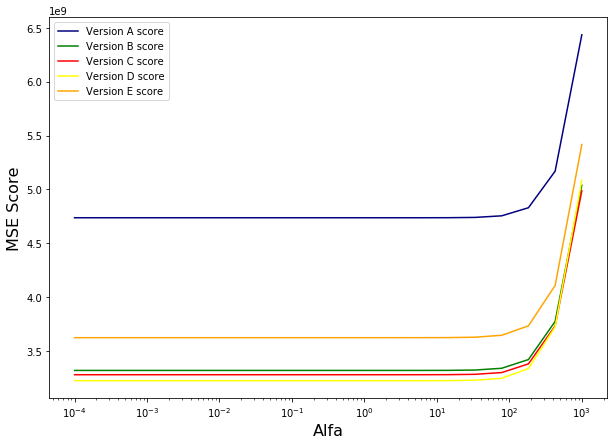

In [12]:
plt.figure(figsize=(10,7))
plt.xlabel("Alfa", fontsize=16)
plt.ylabel("MSE Score", fontsize=16)
lw = 1.5
plt.semilogx(alfas, res[0], label="Version A score", color="navy", lw=lw)
plt.semilogx(alfas, res[1], label="Version B score", color="green", lw=lw)
plt.semilogx(alfas, res[2], label="Version C score", color="red", lw=lw)
plt.semilogx(alfas, res[3], label="Version D score", color="yellow", lw=lw)
plt.semilogx(alfas, res[4], label="Version E score", color="orange", lw=lw)
plt.legend(loc="best")
plt.show()

Dagli esperimenti il dataset con i risultati più promettenti è il D

Confrontiamo i risultati migliori con un modello di regressione lineare

In [13]:
linear = RidgeRegression(alfa=0)
results = []
for alfa, data in zip(best, datasets):
    print(data[0])
    ridge = RidgeRegression(alfa=alfa)
    err_ridge = kfolds.cross_validate(ridge, data[1], "median_house_value", mean_squared_error)
    err_linear = kfolds.cross_validate(linear, data[1], "median_house_value", mean_squared_error)
    diff = err_linear - err_ridge
    diff_perc = round(diff/err_ridge*100,4)
    err_linear = np.around(err_linear)
    err_ridge = np.around(err_ridge)
    print("Linear error: {}, Ridge error: {}, Improvement: {} ({}%)\n".format(err_linear, err_ridge, diff, diff_perc))
    results.append((err_linear, err_ridge, diff, diff_perc))
pd.DataFrame(results, columns=["Linear", "Ridge", "Diff", "% Miglioramento"])

base
Linear error: 4736461511.0, Ridge error: 4736436906.0, Improvement: 24604.224323272705 (0.0005%)

base no out
Linear error: 3318694138.0, Ridge error: 3318690541.0, Improvement: 3596.860201358795 (0.0001%)

add features
Linear error: 3278885746.0, Ridge error: 3278882481.0, Improvement: 3265.516601085663 (0.0001%)

log
Linear error: 3420808260.0, Ridge error: 3223373061.0, Improvement: 197435199.05915785 (6.1251%)

removed
Linear error: 3622858373.0, Ridge error: 3622858374.0, Improvement: -0.44556760787963867 (-0.0%)



,Linear,Ridge,Diff,% Miglioramento
0,4.736462e+09,4.736437e+09,2.460422e+04,0.0005
1,3.318694e+09,3.318691e+09,3.596860e+03,0.0001
2,3.278886e+09,3.278882e+09,3.265517e+03,0.0001
3,3.420808e+09,3.223373e+09,1.974352e+08,6.1251
4,3.622858e+09,3.622858e+09,-4.455676e-01,-0.0000


## Proviamo con PCA 

In [20]:
datasets = [dataA_PCA, dataB_PCA, dataC_PCA, dataD_PCA, dataE_PCA]
best, res, tab  = valuate(datasets, alfas, kfolds, RidgeRegression)

PCA base
0.0001	47870376585.53834
0.0002	47870376582.792755
0.0005	47870376574.55605
0.0013	47870376552.59152
0.003	47870376505.91724
0.007	47870376396.09711
0.0162	47870376143.52002
0.0379	47870375547.81835
0.0886	47870374156.295746
0.2069	47870370910.9242
0.4833	47870363336.59381
1.1288	47870345692.66821
2.6367	47870304721.54841
6.1585	47870210365.183464
14.3845	47869997197.52018
33.5982	47869538008.83044
78.476	47868668130.50394
183.2981	47867642790.28659
428.1332	47869712415.41094
1000.0	47890467950.11195
best alfa:	183.2981
best value:	47867642790.28659

PCA base no out
0.0001	38665123424.63076
0.0002	38665123424.30126
0.0005	38665123423.31279
0.0013	38665123420.676865
0.003	38665123415.07569
0.007	38665123401.89727
0.0162	38665123371.59115
0.0379	38665123300.13182
0.0886	38665123133.30298
0.2069	38665122744.73886
0.4833	38665121840.72127
1.1288	38665119750.41033
2.6367	38665114981.41801
6.1585	38665104463.54886
14.3845	38665083261.90493
33.5982	38665051856.348885
78.476	386650743

In [21]:
tab.style.format("{:.0f}")

,PCA base,PCA base no out,PCA add features,PCA log,PCA removed
0.0001,47870376586,38665123425,38465123038,40455057224,38656717994
0.0002,47870376583,38665123424,38465123038,40455057224,38656717993
0.0005,47870376575,38665123423,38465123039,40455057223,38656717991
0.0013,47870376553,38665123421,38465123043,40455057220,38656717985
0.003,47870376506,38665123415,38465123051,40455057213,38656717973
0.007,47870376396,38665123402,38465123069,40455057198,38656717944
0.0162,47870376144,38665123372,38465123112,40455057162,38656717878
0.0379,47870375548,38665123300,38465123212,40455057079,38656717721
0.0886,47870374156,38665123133,38465123446,40455056883,38656717355
0.2069,47870370911,38665122745,38465123993,40455056429,38656716503


In [22]:
best

[183.2981, 33.5982, 0.0001, 78.476, 78.476]

C si rivela essere il miglior0 in questo, anche se il MSE aumenta di un ordine di magnitudine. Notare come nei casi B e C si ottengano risultati molto simili a quelli di E; PCA applica una sorta di feature selection, cosa che è stata gia fatta nell ultimo caso

Confrontiamo i risultati tra le versioni base e quelle con PCA

In [14]:
pd.concat([tab1, tab], axis = 1)

,base,base no out,add features,log,removed,PCA base,PCA base no out,PCA add features,PCA log,PCA removed
0.0001,4.736462e+09,3.318694e+09,3.278886e+09,3.223375e+09,3.622858e+09,4.787038e+10,3.866512e+10,3.846512e+10,4.045506e+10,3.865672e+10
0.0002,4.736462e+09,3.318694e+09,3.278886e+09,3.223375e+09,3.622858e+09,4.787038e+10,3.866512e+10,3.846512e+10,4.045506e+10,3.865672e+10
0.0005,4.736462e+09,3.318694e+09,3.278886e+09,3.223375e+09,3.622858e+09,4.787038e+10,3.866512e+10,3.846512e+10,4.045506e+10,3.865672e+10
0.0013,4.736461e+09,3.318694e+09,3.278886e+09,3.223375e+09,3.622858e+09,4.787038e+10,3.866512e+10,3.846512e+10,4.045506e+10,3.865672e+10
0.0030,4.736461e+09,3.318694e+09,3.278886e+09,3.223375e+09,3.622858e+09,4.787038e+10,3.866512e+10,3.846512e+10,4.045506e+10,3.865672e+10
0.0070,4.736461e+09,3.318694e+09,3.278886e+09,3.223375e+09,3.622858e+09,4.787038e+10,3.866512e+10,3.846512e+10,4.045506e+10,3.865672e+10
0.0162,4.736461e+09,3.318694e+09,3.278886e+09,3.223375e+09,3.622858e+09,4.787038e+10,3.866512e+10,3.846512e+10,4.045506e+10,3.865672e+10
0.0379,4.736461e+09,3.318694e+09,3.278885e+09,3.223375e+09,3.622859e+09,4.787038e+10,3.866512e+10,3.846512e+10,4.045506e+10,3.865672e+10
0.0886,4.736460e+09,3.318694e+09,3.278885e+09,3.223375e+09,3.622859e+09,4.787037e+10,3.866512e+10,3.846512e+10,4.045506e+10,3.865672e+10
0.2069,4.736458e+09,3.318693e+09,3.278884e+09,3.223374e+09,3.622859e+09,4.787037e+10,3.866512e+10,3.846512e+10,4.045506e+10,3.865672e+10


## Analisi su dataset C

In [5]:
d = dataD[1]
best_alfa = 0.4833

In [7]:
weights = []
models = dict()
for alfa in alfas:
    ridge = RidgeRegression(alfa=alfa)
    model = kfolds.get_best_model(ridge, d, "median_house_value", mean_squared_error)
    weights.append(model.get_weight())
    models[alfa] = model
tab = pd.DataFrame(weights, index=alfas)
tab

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0.0001,-57583.584825,-60403.145811,9141.589366,3463.471275,8426.496457,-7459.967057,572.282690,56782.048107,7592.548188,-19287.356561,12533.553602,205039.126062,171528.333916,195482.604228,199275.962002
0.0002,-57583.579234,-60403.138590,9141.590361,3463.469644,8426.497381,-7459.966624,572.283564,56782.048127,7592.547390,-19287.357371,12533.552421,205039.124468,171528.327768,195482.591884,199275.953768
0.0005,-57583.563222,-60403.117740,9141.592684,3463.469761,8426.495381,-7459.966049,572.285394,56782.048187,7592.544368,-19287.358901,12533.549737,205039.119685,171528.309321,195482.554855,199275.929065
0.0013,-57583.520582,-60403.062190,9141.598844,3463.469652,8426.492222,-7459.964217,572.289016,56782.048347,7592.535884,-19287.362967,12533.541835,205039.106931,171528.260130,195482.456109,199275.863190
0.0030,-57583.429979,-60402.944159,9141.611921,3463.469778,8426.485622,-7459.960593,572.296257,56782.048688,7592.517609,-19287.371518,12533.524990,205039.079829,171528.155600,195482.246274,199275.723206
0.0070,-57583.216817,-60402.666465,9141.642656,3463.470025,8426.470210,-7459.952225,572.313330,56782.049489,7592.474568,-19287.391597,12533.485284,205039.016059,171527.909647,195481.752547,199275.393832
0.0162,-57582.726543,-60402.027763,9141.713358,3463.470631,8426.434765,-7459.932923,572.352558,56782.051331,7592.375544,-19287.437774,12533.393960,205038.869385,171527.343963,195480.616983,199274.636272
0.0379,-57581.570210,-60400.521349,9141.880113,3463.472049,8426.351189,-7459.887452,572.445110,56782.055669,7592.141982,-19287.546676,12533.178553,205038.523414,171526.009727,195477.938577,199272.849422
0.0886,-57578.868951,-60397.002231,9142.269693,3463.475390,8426.155921,-7459.781218,572.661325,56782.065764,7591.596331,-19287.801104,12532.675297,205037.715019,171522.892628,195471.680982,199268.674629
0.2069,-57572.568215,-60388.793566,9143.178531,3463.483201,8425.700374,-7459.533400,573.165738,56782.089106,7590.323407,-19288.394711,12531.501148,205035.828394,171515.620579,195457.081275,199258.933526


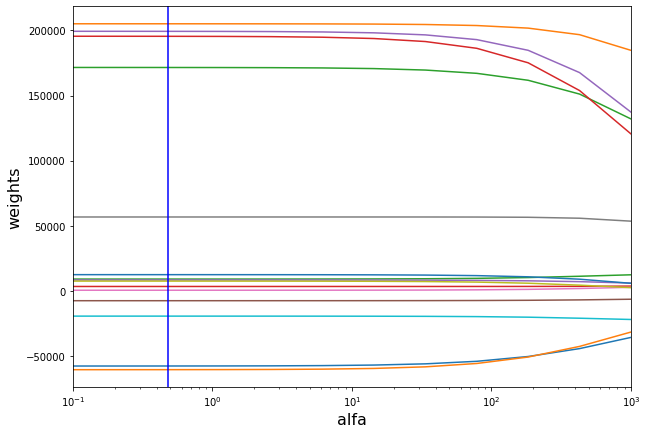

In [8]:
l = range(1, len(weights))
plt.figure(figsize=(10,7))
ax = plt.gca()
ax.plot(alfas, weights)
ax.set_xscale('log')
plt.xlabel('alfa', fontsize=16)
plt.ylabel('weights', fontsize=16)
plt.xlim([0.1, 1000])
plt.axvline(best_alfa, color='b', label='best alfa')
# plt.title('Ridge coefficients as a function of the regularization')
plt.show()

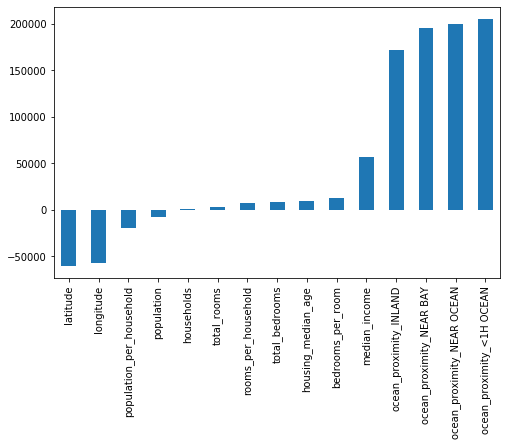

In [22]:
best_model = models[best_alfa]
weights = best_model.get_weight()
features = d.drop(["median_house_value"], axis=1).columns
coef = pd.Series(weights, features).sort_values()
coef.plot(kind='bar', figsize = (8,5))
plt.show()


In [24]:
errors = []
for alfa in alfas:
    ridge = RidgeRegression(alfa=alfa)
    error = kfolds.cross_validate(ridge, d, "median_house_value", mean_squared_error)
    errors.append(error)

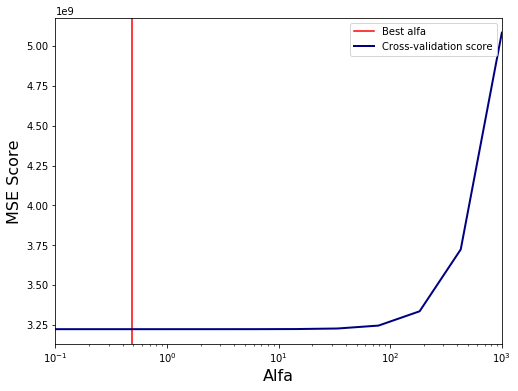

In [39]:
plt.figure(figsize=(8,6))
# plt.title("MSE as a function of the regularization'")
plt.xlabel("Alfa", fontsize=16)
plt.ylabel("MSE Score", fontsize=16)
lw = 2
plt.xlim([0.1, 1000])
plt.axvline(best_alfa, color='r', label='Best alfa')
plt.semilogx(alfas, errors, label="Cross-validation score", color="navy", lw=lw)
plt.legend(loc="best")
plt.show()

## Validazione

In [27]:
d = dataD[1]
best_alfa = 0.4833
folds = 5
kfolds_val = KFoldCV(folds, print=False, shuffle=200)

In [37]:
train_scores = []
test_scores = []
for alfa in alfas:
    ridge = RidgeRegression(alfa=alfa)
    err = kfolds_val.get_train_test_accuracy(ridge, d, "median_house_value", mean_squared_error)
    train_scores.append(err[0])
    test_scores.append(err[1])

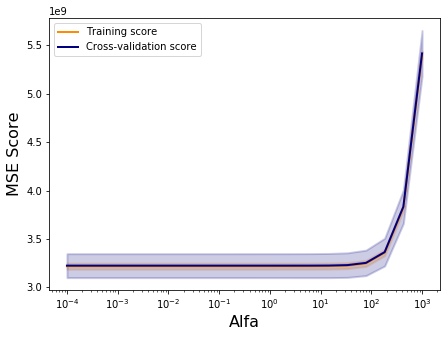

In [38]:
# Calculating mean and standard deviation of training score
train_scores_mean = np.mean(np.abs(train_scores), axis = 1)
train_scores_std = np.std(np.abs(train_scores), axis = 1)
 
# Calculating mean and standard deviation of testing score
test_scores_mean = np.mean(np.abs(test_scores), axis = 1)
test_scores_std = np.std(np.abs(test_scores), axis = 1)

plt.figure(figsize=(7,5))
# plt.title("Validation Curve with Ridge regression")
plt.xlabel("Alfa", fontsize=16)
plt.ylabel("MSE Score", fontsize=16)
lw = 2
plt.semilogx(alfas, train_scores_mean, label="Training score", color="darkorange", lw=lw)
plt.fill_between(alfas, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.semilogx(alfas, test_scores_mean, label="Cross-validation score", color="navy", lw=lw)
plt.fill_between(alfas, test_scores_mean - test_scores_std,  test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.show()

In [55]:
best_alfa = 0.4833
ridge = RidgeRegression(alfa=best_alfa)

train_sizes=np.round(np.linspace(.1, 1.0, 20), 4)

train_scores = []
test_scores = []
for n in train_sizes:
    d_frac = d.sample(frac=n, random_state=100)
    err = kfolds_val.get_train_test_accuracy(ridge, d_frac, "median_house_value", mean_squared_error)
    train_scores.append(err[0])
    test_scores.append(err[1])

In [65]:
train_scores = []
test_scores = []
d = d.sample(frac=1, random_state=0)
num_data = len(d)
for n in train_sizes:
    d_frac = d[:int(n*num_data)]
    err = kfolds_val.get_train_test_accuracy(ridge, d_frac, "median_house_value", mean_squared_error)
    train_scores.append(err[0])
    test_scores.append(err[1])

In [66]:
train_sizes

array([0.1   , 0.1474, 0.1947, 0.2421, 0.2895, 0.3368, 0.3842, 0.4316,
       0.4789, 0.5263, 0.5737, 0.6211, 0.6684, 0.7158, 0.7632, 0.8105,
       0.8579, 0.9053, 0.9526, 1.    ])

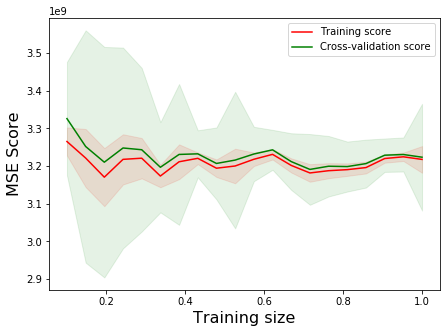

In [67]:
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Plot learning curve
plt.figure(figsize=(7,5))
# plt.title("Learning curve with Ridge regression")
plt.xlabel("Training size", fontsize=16)
plt.ylabel("MSE Score", fontsize=16)
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1,
                     color="g")
plt.plot(train_sizes, train_scores_mean, color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean, color="g", label="Cross-validation score")
plt.legend(loc="best")
plt.show()

## Proviamo a fare una stima migliore dell'errore con Nested CV

Definiamo il numero di fold interni ed esterni e l'insieme di parametri

In [49]:
internal_folds = 5
folds = 10

Facciamo la stima dell'errore con Nested Cross Validation

In [51]:
errors_nested = list()
errors_best_model = list()
exp = range(1,21)

for i in exp:
    print(i)
    nestedKFolds = NestedCV(folds, internal_folds, shuffle=i, print=False)
    kfolds = KFoldCV(folds, print=False, shuffle=i)
    
    # compute cv on all alfas values
    kfold_estimate = list()
    for alfa in alfas:
        ridge = RidgeRegression(alfa=alfa)
        err = kfolds.cross_validate(ridge, d, "median_house_value", mean_squared_error)
        kfold_estimate.append(err)
    # get the best estimates on optimized paramter alfa
    m = min(kfold_estimate)
    errors_best_model.append(m)
    
    # nested estimates
    nested_error = nestedKFolds.cross_validate(RidgeRegression, d, "median_house_value", mean_squared_error, alfas)
    errors_nested.append(nested_error)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


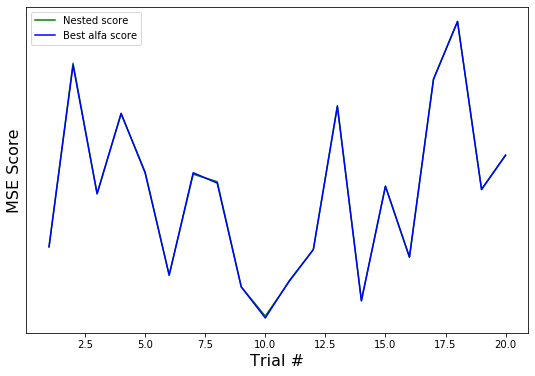

In [63]:
plt.figure(figsize=(9,6))
# plt.title("Nested vs Non-nested CV estimates")
plt.xlabel("Trial #", fontsize=16)
plt.ylabel("MSE Score", fontsize=16)
#plt.plot(exp, errors_kfold, color="r", label="K-Fold score")
plt.plot(exp, errors_nested, color="g", label="Nested score")
plt.plot(exp, errors_best_model, color="b", label="Best alfa score")
plt.legend(loc="best")
plt.show()

In [64]:
score_difference

[0.0,
 21578.971909046173,
 -3408.734384536743,
 -7741.547235012054,
 12733.850133419037,
 228.427668094635,
 -17055.670573234558,
 15743.251630783081,
 1030.898546218872,
 20684.92504119873,
 -8420.669469356537,
 0.0,
 9240.97698545456,
 7838.049906253815,
 -733.6418209075928,
 -6978.01990032196,
 6916.686019897461,
 480.19245195388794,
 -4831.010137557983,
 -5212.706792354584]

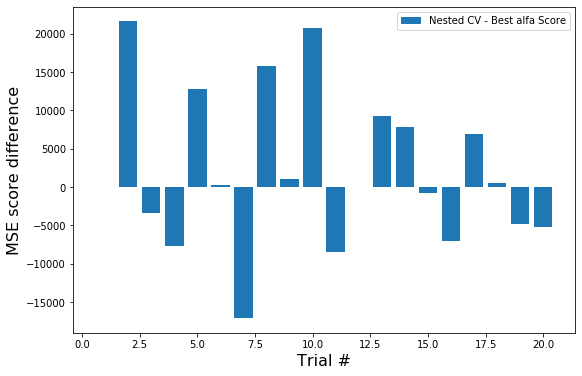

In [60]:
score_difference = [i-j for i, j in zip(errors_nested, errors_best_model)]

plt.figure(figsize=(9,6))
# plt.title("Difference in the estimates")
plt.bar(exp, score_difference)
plt.xlabel("Trial #", fontsize=16)
plt.legend(["Nested CV - Best alfa Score"], loc="best")
plt.ylabel("MSE score difference", fontsize=16)
plt.show()

Guardiamo la stabilità dei risultati considerando il valore di alfa e il risultato del modello corrispondente sia sull'inner che l'outer cv

In [77]:
nestedKFolds = NestedCV(folds, internal_folds, shuffle=200, print=True)
alfa_vals, inner, outer = nestedKFolds.get_inner_outer_estimates(RidgeRegression, d, "median_house_value", mean_squared_error, alfas)

In [80]:
diff = np.array(inner)-np.array(outer)
data = {"Alfa":alfa_vals, "Inner estimates": inner, "Outer estimates": outer, "Difference": diff}
df = pd.DataFrame(data)
df['Inner estimates'] = df['Inner estimates'].astype('int64')
df['Outer estimates'] = df['Outer estimates'].astype('int64')
df['Difference'] = df['Difference'].astype('int64')
df

,Alfa,Inner estimates,Outer estimates,Difference
0,0.0379,3244041372,3024575692,219465680
1,0.0886,3229758226,3152255327,77502898
2,0.2069,3203971576,3397892087,-193920510
3,0.2069,3196485766,3459274065,-262788298
4,0.4833,3228369081,3174360549,54008532
5,0.4833,3204195047,3397304656,-193109609
6,0.4833,3233417668,3135711690,97705977
7,0.2069,3221267340,3240943946,-19676605
8,0.4833,3225884640,3201376491,24508148
9,0.4833,3243706846,3041002340,202704506


In [76]:
error = nestedKFolds.cross_validate(RidgeRegression, d, "median_house_value", mean_squared_error, alfas)

External fold num: 1
Testing with value 0.0001 with error : 3218908401.771743
Testing with value 0.0002 with error : 3218908400.8817406
Testing with value 0.0005 with error : 3218908399.3186584
Testing with value 0.0013 with error : 3218908394.240057
Testing with value 0.003 with error : 3218908383.729538
Testing with value 0.007 with error : 3218908359.1835513
Testing with value 0.0162 with error : 3218908303.442066
Testing with value 0.0379 with error : 3218908176.241083
Testing with value 0.0886 with error : 3218907902.3381715
Testing with value 0.2069 with error : 3218907390.0767865
Testing with value 0.4833 with error : 3218906884.9768486
Testing with value 1.1288 with error : 3218909473.421081
Testing with value 2.6367 with error : 3218936012.6331425
Testing with value 6.1585 with error : 3219108929.036741
Testing with value 14.3845 with error : 3220107282.5835457
Testing with value 33.5982 with error : 3225551428.984535
Testing with value 78.476 with error : 3253730394.985786
Te

Testing with value 6.1585 with error : 3230939936.594051
Testing with value 14.3845 with error : 3231902665.6663346
Testing with value 33.5982 with error : 3237245486.566579
Testing with value 78.476 with error : 3265109378.6979146
Testing with value 183.2981 with error : 3398539574.148262
Testing with value 428.1332 with error : 3950393860.277257
Testing with value 1000.0 with error : 5759989160.913967
The best parameter on interal folds is 0.4833, with error on external fold: 3155074023.0070004

External fold num: 8
Testing with value 0.0001 with error : 3209819372.070893
Testing with value 0.0002 with error : 3209819371.0215535
Testing with value 0.0005 with error : 3209819366.9699144
Testing with value 0.0013 with error : 3209819356.175289
Testing with value 0.003 with error : 3209819333.241769
Testing with value 0.007 with error : 3209819279.353558
Testing with value 0.0162 with error : 3209819156.2509937
Testing with value 0.0379 with error : 3209818870.147745
Testing with value 

In [26]:
error

3278847727.45735